# Run GP

*Last updated Monday, 06 Sep 2021.*

=====================================================================================================
1. **Load data**

2. **Find GP**

3. **Results**
    1. Kernel overview
    2. Find minimum of GP mean
    3. Plot GP

=====================================================================================================

## 1. Load data
Load data from R code. Column 0, 1 are mass donor and orbital period, respectively. Colmn 15 has error.

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import genfromtxt

Choose if caso conservativo:

In [97]:
typ = "fixed"
typ = "free"

errorIndex = 1
errorNames = ['teffError3', 'cnError3', 'massError3', 'mdotError3']
labelNames = ['$T_{eff}$', 'log C/N', 'mass', 'M^dot}']

Load data.

In [98]:
if typ == "fixed":
    errorSimulations = pd.read_csv('Output_errorFromR/File20210917_R04_EBVfixed_sim1to3_errors3.csv', delimiter=',')
else:
    errorSimulations = pd.read_csv('Output_errorFromR/File20210917_R04_EBVfree_sim1_errors3.csv', delimiter=',')
errorSimulations[errorNames] = errorSimulations[errorNames].fillna(value = 10)

X_init = errorSimulations[['mass', 'porb']]
Y_init = errorSimulations[[errorNames[errorIndex]]]


## 2. Gaussian process model
Run GPflow to fit current data to a Gaussian process

In [49]:
import gpflow
import tensorflow as tf
from gpflow.utilities import print_summary

In [101]:
k = gpflow.kernels.Matern32(lengthscales = [0.25, 0.25]) # fixed [0.01, 0.01]
m = gpflow.models.GPR(data=(X_init, np.log(Y_init)), kernel=k, mean_function=None)
opt = gpflow.optimizers.Scipy()

opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                   │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.193532758944407       │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [0.35606684 0.14185918] │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ floa

## 3. Results

### *Kernel overview (optional)
Plot kernel (as in https://gpflow.readthedocs.io/en/master/notebooks/advanced/kernels.html):

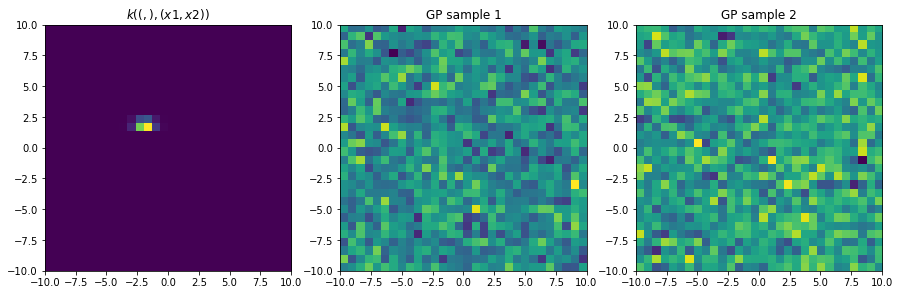

In [102]:
n_grid = 30
x = np.linspace(-10, 10, n_grid)
X, Y = np.meshgrid(x, x)
X = np.vstack((X.flatten(), Y.flatten())).T

# plot the kernel
x0 = np.array([[-2.0, -2.0]])
KxX = k(X, x0).numpy().reshape(n_grid, n_grid)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(KxX, extent=[-10, 10, -10, 10])
axes[0].set_title(f"$k(( , ), (x1, x2))$")

# plot a GP sample
K = k(X).numpy()
Z = np.random.multivariate_normal(np.zeros(n_grid ** 2), K, 2)
axes[1].imshow(Z[0, :].reshape(n_grid, n_grid), extent=[-10, 10, -10, 10])
axes[1].set_title("GP sample 1")
axes[2].imshow(Z[1, :].reshape(n_grid, n_grid), extent=[-10, 10, -10, 10])
_ = axes[2].set_title("GP sample 2")

### Find minimum of GP
Find minimum of mean of GP posterior, using a spicy optimiser

In [103]:
from scipy.optimize import minimize

def minFn(x):
    mean, var = m.predict_f(np.array([x]))
    return mean.numpy()[0][0]

# Run minimiser
x0 = np.array([0.98, 3.12])
res = minimize(minFn, x0, method='nelder-mead')

# Save in minGP
minGP = res.x

# (Fixed) Minimum is: array([0.98000933, 3.11893855])
# (Free) Minimum is:
minGP

array([-25.33673242,  73.27361133])

### Plot GP
Plot mean GP, current points, minimum

Text(0.5, 1.0, 'Variance of GP for log C/N')

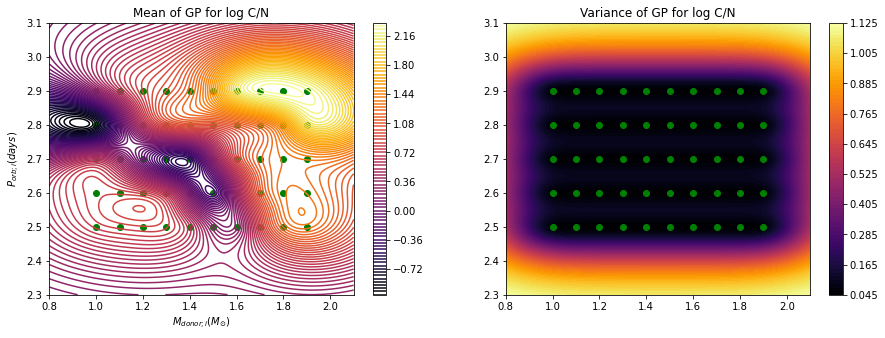

In [106]:
import matplotlib.pyplot as plt

## generate test points for prediction/interpolation
n_grid = 200
x = np.linspace(0.8, 2.1, n_grid)
y = np.linspace(2.3, 3.1, n_grid) # 3.5 3.1
Xg, Yg = np.meshgrid(x, y)
X = np.vstack((Xg.flatten(), Yg.flatten())).T

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(X)
meanX = mean.numpy().reshape(n_grid, n_grid)
varX = var.numpy().reshape(n_grid, n_grid)

## plot GP
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.contour(x, y, meanX, 100, cmap = "inferno")
plt.colorbar()
plt.scatter(X_init['mass'], X_init['porb'], label=u'Observations', c = "green")
#plt.scatter(x[np.where(meanX == np.amin(meanX))[1]],
#            y[np.where(meanX == np.amin(meanX))[0]], label=u'Observations', c = "red")
####plt.scatter(minGP[0], minGP[1], label=u'Observations', c = "red")
plt.xlabel("$M_{donor;i}(M_{\odot})$")
plt.ylabel("$P_{orb;i}(days)$")
plt.title("Mean of GP for %s" % labelNames[errorIndex])

# plot variance of GP
plt.subplot(1, 2, 2)
plt.contourf(x, y, varX, 100, cmap = "inferno")
plt.colorbar()
plt.scatter(X_init['mass'], X_init['porb'], label=u'Observations', c = "green")
###plt.scatter(minGP[0], minGP[1], label=u'Observations', c = "red")
plt.title("Variance of GP for %s" % labelNames[errorIndex])

# TODO: reshape does something weird with the dimensions?
